In [1]:
# Fix seeds
#from numpy.random import seed
#seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)

import numpy as np 
import pandas as pd
import os
from tqdm import tqdm
import time
from IPython import display
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import tensorflow as tf
import keras
from keras import layers, models, activations



Using TensorFlow backend.


In [2]:
# Import data
data = pd.read_csv("../input/train.csv", dtype={"acoustic_data": np.int16, "time_to_failure": np.float32}).values

In [3]:
#len(data)
data_len = 629145480
segment_len = 150000

In [4]:
# Get 1000 independent chunk of 150,000 sample as Validation Test: first and last 500

val_id1 = np.arange(0,500)*segment_len

val_id2 = np.sort(np.abs( (val_id1 - data_len) ) - segment_len)

val_id = np.concatenate((val_id1, val_id2))

train_id_m = val_id1[-1]+segment_len
train_id_M = val_id2[0]-segment_len

print("Train id from",train_id_m,"to",train_id_M)
print("Num of Validation segments :",len(val_id))

Train id from 75000000 to 553995480
Num of Validation segments : 1000


In [5]:
# How many training segment?
print((train_id_M-train_id_m)/segment_len)

3193.3032


In [6]:
# train indexes

train_id = np.arange(train_id_m, train_id_M-segment_len, segment_len, dtype=np.int)
print(train_id)
print(len(train_id))

[ 75000000  75150000  75300000 ... 553500000 553650000 553800000]
3193


In [7]:
# what's the margin to slide the indexes?
marg = train_id_M-train_id[-1]
print(marg)

195480


In [8]:
# 19548 / 36
slide = np.linspace(0, 19548, 544)
print(slide.shape)


(544,)


In [9]:
# creat a useful dictionary structures for data generation

partition = {}
partition['train'] = train_id
partition['validation'] = val_id

In [10]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, Slide, batch_size=32, dim=150000, n_channels=1,
                 n_classes=1, shuffle=True, train=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.Slide = Slide
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        # Initialization
        X = np.empty((self.batch_size, self.dim, self.n_channels), dtype=np.int16)
        y = np.empty((self.batch_size, self.n_classes), dtype=np.float64)
        off = 0
        
        if self.train:
            off = np.random.choice(self.Slide) # generate a random offset
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            temp = data[ID+off :ID+off+150000 ,0]
            X[i] = np.expand_dims(temp, axis=2)   
           
            # Store target labels
            y[i] = data[ID+off+150000-1 ,1]

        return X, y

In [11]:
def build_neural_network(data_size_in, n_classes):
        
    inputs = layers.Input(shape=data_size_in)
    
    x = layers.Conv1D(kernel_size=5000, filters=8, activation='relu')(inputs)
    
    #x = layers.Conv1D(kernel_size=5000, filters=8, activation='relu')(x)
    
    x = layers.normalization.BatchNormalization()(x)
    
    x = layers.AveragePooling1D(pool_size=3)(x)
    
    x = layers.Conv1D(kernel_size=1000, filters=8, activation='relu')(x)
    
    #x = layers.Conv1D(kernel_size=1000, filters=8, activation='relu')(x)
    
    x = layers.normalization.BatchNormalization()(x)
    
    x = layers.AveragePooling1D(pool_size=3)(x)
    
    x = layers.Conv1D(kernel_size=500, filters=16, activation='relu')(x)
    
    #x = layers.Conv1D(kernel_size=500, filters=16, activation='relu')(x)
    
    x = layers.normalization.BatchNormalization()(x)
    
    x = layers.AveragePooling1D(pool_size=3)(x)
    
    x = layers.Conv1D(kernel_size=500, filters=16, activation='relu')(x)
    
    #x = layers.Conv1D(kernel_size=500, filters=16, activation='relu')(x)
    
    x = layers.normalization.BatchNormalization()(x)
    
    x = layers.AveragePooling1D(pool_size=3)(x)
    
    x = layers.Conv1D(kernel_size=150, filters=32, activation='relu')(x)
    
    #x = layers.Conv1D(kernel_size=150, filters=32, activation='relu')(x)
    
    x = layers.normalization.BatchNormalization()(x)
    
    x = layers.AveragePooling1D(pool_size=3)(x)
    
    x = layers.Conv1D(kernel_size=150, filters=64, activation='relu')(x)
    
    #x = layers.Conv1D(kernel_size=150, filters=64, activation='relu')(x)
    
    x = layers.normalization.BatchNormalization()(x)
    
    x = layers.MaxPool1D(pool_size=3)(x)
    
    x = layers.Flatten()(x)
        
    x = layers.Dense(units=500, activation='sigmoid')(x)
    
    x = layers.Dropout(rate=0.5)(x)
    
    x = layers.Dense(units=25, activation='relu')(x)
    
    predictions = layers.Dense(units=n_classes, activation='linear')(x)
    
    
    model = keras.models.Model(inputs=inputs, outputs=predictions)
    
    
    print(model.summary())
    return model

In [12]:
data_size_in=(150000,1)
n_classes=1

In [13]:
### Replace None with your code ###
loss = 'mean_absolute_error'  
learning_rate = 0.01 
sgd = keras.optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
metrics = [keras.metrics.mae]

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
network = build_neural_network(data_size_in, n_classes)
network.compile(loss=loss, optimizer=sgd, metrics=metrics)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150000, 1)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 145001, 8)         40008     
_________________________________________________________________
batch_normalization_1 (Batch (None, 145001, 8)         32        
_________________________________________________________________
average_pooling1d_1 (Average (None, 48333, 8)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 47334, 8)          64008     
_________________________________________________________________
batch_normalization_2 (Batch (None, 47334, 8)          32        
___________________________

In [15]:
def train_network(network, training_generator, validation_generator, n_epoch, network_filepath):


    
    # lists where we will be storing values during training, for visualization purposes
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy

    # we want to save the parameters that give the best performance on the validation set
    # therefore, we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 100000000 # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train your network
        results = network.fit_generator(training_generator)

        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['mean_absolute_error']

        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate_generator(validation_generator)     
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy < best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'g')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt], 
                  ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                  loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation mae = {:.2f}'.format(best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.2)

In [16]:
# Define batch size.
batch_size = 32
n_epoch = 50
slide = np.linspace(0, 19548, 544, dtype=np.int)


# Parameters
params = {'Slide' : slide,
          'dim': 150000,
          'batch_size': batch_size,
          'n_classes': 1,
          'shuffle': True}

# Generators
training_generator = DataGenerator(partition['train'], **params, train = True)
validation_generator = DataGenerator(partition['validation'], **params, train = False)

In [17]:
file_dir = '../working//Model'
network_filepath = os.path.join(file_dir, 'best_model.h5')
os.mkdir(file_dir)

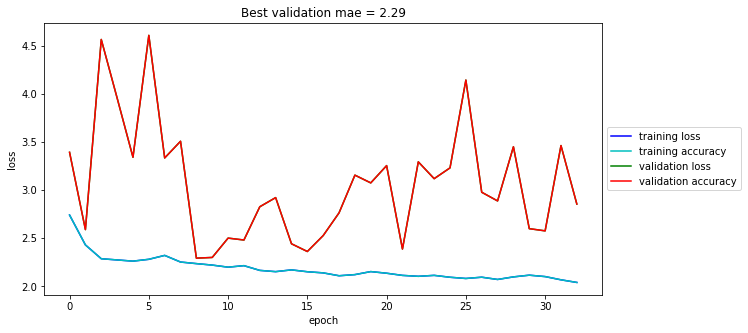

Epoch 1/1
65/99 [==================>...........] - ETA: 57s - loss: 2.0732 - mean_absolute_error: 2.0732

In [18]:
train_network(network, training_generator, validation_generator, n_epoch, network_filepath)

In [19]:
#### Re-load the model found for the best accuracy; load_model function takes care of compiling again the function 

#best_network=keras.models.load_model(network_filepath)

In [20]:
#test = np.empty((2624,150000,1), dtype=np.float)
#for i, seg in enumerate(os.listdir("../input/test/")):
#    test[i] = pd.read_csv("../input/test/"+seg).values
    

In [21]:
#pred = best_network.predict_on_batch(test)